# Ejercicio OpenStreetMap
Para este ejercicio vas a trabar con Overpass, que es la API que utiliza los datos de OpenStreetMap. Tras obtener datos geográficos mediante la API, tendrás que representarlos con Plotly.

Hay que obtener los siguientes datos de cada ubicación conseguida en OpenStreetMap
* tipo de amenity
* latitud
* longitud
* nombre
* direccion

**NOTA**: En este Notebook utilizarás gráficas de Plotly, y JupyterLab de momento no lo soporta, a no ser que instales una extensión. Para solucionar esto, abre el Notebook desde Jupyter normal:

![imagen](./img/jupyter.png)

Tienes en [este enlace](https://wiki.openstreetmap.org/wiki/Key:amenity#Healthcare) la lista de *amenities* que vas a usar en el notebook.

## Instalación
Si no tienes instalado Plotly, abre un terminal y escribe:
```
pip install plotly
```

Importa las librerias que vamos a usar en el Notebook

In [9]:

pip install plotly


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import requests
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import plotly.express as px

In [ ]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster

In [ ]:
import requests
import pandas as pd
import folium
from folium.plugins import MarkerCluster

In [ ]:
overpass_url = "https://overpass-api.de/api/interpreter" 

Bounding box (latS, lonW, latN, lonE)

In [ ]:
latS, lonW = 40.420801, -3.694702
latN, lonE = 40.423754, -3.688167

Ataca a la API de OpenStreetmap con el siguiente código de ejemplo

overpass_query = f"""
[out:json][timeout:25];
(
  node["amenity"="ice_cream"]({latS},{lonW},{latN},{lonE});
  way["amenity"="ice_cream"]({latS},{lonW},{latN},{lonE});
  relation["amenity"="ice_cream"]({latS},{lonW},{latN},{lonE});
);
out center tags;
"""

In [ ]:
 Parseo a filas (id, type, lat, lon, name...

rows = []
for el in elements:
    el_type = el.get("type")
    el_id = el.get("id")
    tags = el.get("tags", {}) or {}

 Coordenadas: nodes tienen lat/lon; ways/relations usan 'center'

In [ ]:

    if el_type == "node":
        lat, lon = el.get("lat"), el.get("lon")
    else:
        center = el.get("center") or {}
        lat, lon = center.get("lat"), center.get("lon")

    if lat is None or lon is None:
        continue

    rows.append({
        "osm_id": el_id,
        "osm_type": el_type,
        "name": tags.get("name"),
        "brand": tags.get("brand"),
        "operator": tags.get("operator"),
        "addr:street": tags.get("addr:street"),
        "addr:housenumber": tags.get("addr:housenumber"),
        "lat": lat,
        "lon": lon})

df = pd.DataFrame(rows)
print(f"Elementos encontrados: {len(df)}")
display(df.head(10))

center_lat = (latS + latN) / 2
center_lon = (lonW + lonE) / 2
m = folium.Map(location=[center_lat, center_lon], zoom_start=16, control_scale=True)
mc = MarkerCluster().add_to(m)

def safe(v):
    return "" if pd.isna(v) else v

for _, r in df.iterrows():
    popup_html = (
        f"<b>{safe(r['name']) or 'Heladería'}</b><br>"
        f"Brand: {safe(r['brand'])}<br>"
        f"Operador: {safe(r['operator'])}<br>"
        f"Dirección: {safe(r['addr:street'])} {safe(r['addr:housenumber'])}<br>"
        f"OSM: {r['osm_type']}/{r['osm_id']}")
    folium.CircleMarker(
        location=[r["lat"], r["lon"]],
        radius=5,
        weight=1,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_html, max_width=350),
        tooltip=r["name"] if pd.notna(r["name"]) else "ice_cream" ).add_to(mc)

m



Elementos encontrados (amenity=ice_cream): 0


""


In [14]:
data

{'version': 0.6,
 'generator': 'Overpass API 0.7.62.8 e802775f',
 'osm3s': {'timestamp_osm_base': '2025-11-11T00:09:57Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': []}

Con el siguiente código podrás adaptar el JSON que devuelve la API, a un formato DataFrame más amigable

In [15]:
def json_to_df(data):
    elements = data['elements']
    places = {'tipo': [], 'lat': [], 'lon': [], 'name': [], 'address': []}
    
    for i in elements:
        
        tipo = i.get('tags', None).get('amenity', None)
        latitude = i.get('lat', None)
        longitude = i.get('lon', None)
        name = i.get('tags', {}).get('name', "NO NAME")
        street = i.get('tags', {}).get('addr:street', "NO STREET")
        number = i.get('tags', {}).get('addr:housenumber', 9999)

        places['tipo'].append(tipo)
        places['lat'].append(latitude)
        places['lon'].append(longitude)
        places['name'].append(name)
        places['address'].append(street + ' ' + str(number))

            
    return pd.DataFrame(places)

Utilizarás esta función para representar los datos en un mapa de Matplotlib

In [ ]:
mapbox_access_token = "x"

def pinta_mapa(df):
    fig = px.scatter_mapbox(df,
                            lat="lat",
                            lon="lon",
                            color = "tipo",
                      color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=11)
    fig.update_layout(
        mapbox=dict(accesstoken=mapbox_access_token))

    fig.show()

Como ejemplo, si quiero ver cuántos restaurantes tengo cerca de The Bridge:

In [17]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
node["amenity"="restaurant"]
  (40.420801, -3.694702,40.423754, -3.688167); 
out;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
print(response)
data = response.json()
df = json_to_df(data)
df

<Response [200]>


,tipo,lat,lon,name,address
0,restaurant,40.423086,-3.693547,La Castafiore,NO STREET 9999
1,restaurant,40.422607,-3.693256,Sake Dining Himawari,NO STREET 9999
2,restaurant,40.423315,-3.692506,Ainhoa,Calle de Doña Bárbara de Braganza 12
3,restaurant,40.421972,-3.694272,La Kitchen,NO STREET 9999
4,restaurant,40.422406,-3.693028,Regañadientes,Calle del Almirante 24
5,restaurant,40.421980,-3.693537,Tampu,Calle de Prim 13
6,restaurant,40.423132,-3.694039,Taqueria La Lupita,Calle del Conde de Xiquena 9999
7,restaurant,40.423345,-3.692632,El Gato Persa,Calle de Doña Bárbara de Braganza 10
8,restaurant,40.423386,-3.694036,Shuwa Shuwa,Calle del Conde de Xiquena 12
9,restaurant,40.421948,-3.690353,mama chico,NO STREET 9999


In [18]:
data

{'version': 0.6,
 'generator': 'Overpass API 0.7.62.8 e802775f',
 'osm3s': {'timestamp_osm_base': '2025-11-11T00:11:00Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'node',
   'id': 305536401,
   'lat': 40.4230858,
   'lon': -3.6935468,
   'tags': {'amenity': 'restaurant',
    'check_date': '2024-09-04',
    'name': 'La Castafiore',
    'wheelchair': 'limited'}},
  {'type': 'node',
   'id': 324580483,
   'lat': 40.4226068,
   'lon': -3.6932565,
   'tags': {'amenity': 'restaurant',
    'cuisine': 'japanese',
    'name': 'Sake Dining Himawari'}},
  {'type': 'node',
   'id': 3361315181,
   'lat': 40.4233148,
   'lon': -3.6925055,
   'tags': {'addr:city': 'Madrid',
    'addr:housenumber': '12',
    'addr:postcode': '28004',
    'addr:street': 'Calle de Doña Bárbara de Braganza',
    'amenity': 'restaurant',
    'cuisine': 'regional',
    'name': 'Ainhoa',
    'phone': '+34 913 08 27 26',

In [19]:
pinta_mapa(df)

## Ejercicio 1
### Búsqueda de aparcamiento
Para este caso de uso imagina que vas a Madrid de viaje y estás buscando posibles parkings donde dejar el coche, crea un DataFrame con todos los parkings (de OpenStreetMap) de la ciudad de Madrid. Para ello define una cuadrícula con dos coordenadas sobre Madrid.

Representa en un mapa los resultados

In [ ]:
overpass_url = "https://overpass-api.de/api/interpreter"
query = f
"""[out:json][timeout:30];
(node["amenity"="parking"]({lat_min},{lon_min},{lat_max},{lon_max});way["amenity"="parking"]({lat_min},{lon_min},{lat_max},{lon_max});relation["amenity"="parking"]({lat_min},{lon_min},{lat_max},{lon_max}););
out center tags;
"""

resp = requests.get(overpass_url, params={"data": query}, timeout=60)
resp.raise_for_status()
data = resp.json()
elements = data.get("elements", [])

In [ ]:
rows = []
for el in elements:
    etype = el.get("type")
    eid = el.get("id")
    tags = el.get("tags", {}) or {}

dos coordenadas: SO y NE

In [ ]:
lat_min, lon_min = 40.312, -3.888   
lat_max, lon_max = 40.563, -3.517 

In [ ]:


    if etype == "node":
        lat, lon = el.get("lat"), el.get("lon")
    else:
        c = el.get("center") or {}
        lat, lon = c.get("lat"), c.get("lon")

    if lat is None or lon is None:
        continue

    rows.append({
        "osm_type": etype,
        "osm_id": eid,
        "name": tags.get("name"),
        "parking": tags.get("parking"),      
        "capacity": tags.get("capacity"),
        "access": tags.get("access"),
        "operator": tags.get("operator"),
        "fee": tags.get("fee"),
        "maxstay": tags.get("maxstay"),
        "levels": tags.get("levels"),
        "lat": lat,
        "lon": lon
    })

df = pd.DataFrame(rows)
print(f"Total parkings encontrados: {len(df):,}")
display(df.head(10))




Total parkings encontrados: 8,137


,osm_type,osm_id,name,parking,capacity,access,operator,fee,maxstay,levels,lat,lon
0,node,25911220,None,None,None,None,None,None,None,None,40.394325,-3.794810
1,node,25911223,None,None,None,None,None,None,None,None,40.394064,-3.794909
2,node,25913369,None,underground,None,customers,None,no,None,None,40.398227,-3.783834
3,node,26080782,Princesa 25,underground,None,None,None,None,None,None,40.426712,-3.714370
4,node,26341193,Parking Benavente,underground,285,yes,EMT Madrid,yes,None,None,40.414469,-3.703549
5,node,26495410,None,underground,None,None,None,None,None,None,40.406444,-3.708171
6,node,243535972,None,None,None,None,None,None,None,None,40.447447,-3.627856
7,node,259641875,Parking Privado Monseñor Oscar Romero,underground,None,private,None,None,None,None,40.382132,-3.751128
8,node,264510510,None,underground,None,None,None,None,None,None,40.464152,-3.806718
9,node,267093526,APARCAMIENTO PÚBLICO PZA. CONCORDIA,underground,None,yes,Empresa Municipal del Suelo Y Vivienda de Boad...,yes,None,None,40.407592,-3.877275


MAPA FOLIUM

In [ ]:
def safe(v):  # evita mostrar "nan"
    return "" if (v is None or pd.isna(v)) else v

if not df.empty:
    center_lat = float(df["lat"].mean())
    center_lon = float(df["lon"].mean())
    m = folium.Map(location=[center_lat, center_lon], zoom_start=15, control_scale=True)
    mc = MarkerCluster().add_to(m)

    for _, r in df.iterrows():
        popup_html = (
            f"<b>{safe(r['name']) or 'Parking'}</b><br>"
            f"Tipo: {safe(r['parking'])}<br>"
            f"Capacidad: {safe(r['capacity'])}<br>"
            f"Acceso: {safe(r['access'])}<br>"
            f"Operador: {safe(r['operator'])}<br>"
            f"Tarifa (fee): {safe(r['fee'])}<br>"
            f"Estancia máx: {safe(r['maxstay'])}<br>"
            f"Niveles: {safe(r['levels'])}<br>"
            f"OSM: {r['osm_type']}/{r['osm_id']}" )
        folium.CircleMarker(
            location=[float(r["lat"]), float(r["lon"])],
            radius=5,
            weight=1,
            fill=True,
            fill_opacity=0.85,
            popup=folium.Popup(popup_html, max_width=360),
            tooltip=(r["name"] if pd.notna(r["name"]) else "parking")).add_to(mc)

    m 

## Mudanza
Imagina que te quieres mudar al Berrueco, pero antes te gustaría obtener algún indicador de si hay civilización por esa zona. Mira a ver si existe gasolineras y/o colegios por la zona. Define, al igual que en el caso anterior, un rectángulo mediante dos coordenadas. Busca la manera de realizar una única petición a la API.

Representa después en un mapa, por color los colegios y gasolineras

In [ ]:
lat_min, lon_min = 40.860, -3.620   
lat_max, lon_max = 40.940, -3.480   

In [ ]:
overpass_url = "https://overpass-api.de/api/interpreter"
query = f"""
[out:json][timeout:40];
(
  node["amenity"~"^(fuel|school)$"]({lat_min},{lon_min},{lat_max},{lon_max});
  way["amenity"~"^(fuel|school)$"]({lat_min},{lon_min},{lat_max},{lon_max});
  relation["amenity"~"^(fuel|school)$"]({lat_min},{lon_min},{lat_max},{lon_max});
);
out center tags;
"""

resp = requests.get(overpass_url, params={"data": query}, timeout=90)
resp.raise_for_status()
data = resp.json()
elements = data.get("elements", [])

Parseo AMENITY

In [ ]:
rows = []
for el in elements:
    etype = el.get("type")
    eid = el.get("id")
    tags = el.get("tags", {}) or {}
    amenity = tags.get("amenity")

In [ ]:

    if etype == "node":
        lat, lon = el.get("lat"), el.get("lon")
    else:
        c = el.get("center") or {}
        lat, lon = c.get("lat"), c.get("lon")
    if lat is None or lon is None:
        continue

    rows.append({
        "osm_type": etype,
        "osm_id": eid,
        "categoria": "colegio" if amenity == "school" else ("gasolinera" if amenity == "fuel" else amenity),
        "name": tags.get("name"),
        "operator": tags.get("operator"),
        "brand": tags.get("brand"),
        "addr:street": tags.get("addr:street"),
        "addr:housenumber": tags.get("addr:housenumber"),
        "lat": lat,
        "lon": lon})

df = pd.DataFrame(rows)
print(f"Resultados en el bbox de El Berrueco — Total: {len(df):,}")
if not df.empty:
    print(df["categoria"].value_counts())
    display(df.head(10))

Mapa Folium por categoría

In [ ]:
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2
m = folium.Map(location=[center_lat, center_lon], zoom_start=13, control_scale=True)


fg_colegios = folium.FeatureGroup(name="Colegios", show=True)
fg_gasol = folium.FeatureGroup(name="Gasolineras", show=True)

mc_colegios = MarkerCluster(name="Colegios (cluster)").add_to(fg_colegios)
mc_gasol    = MarkerCluster(name="Gasolineras (cluster)").add_to(fg_gasol)

def safe(v): 
    return "" if pd.isna(v) else v

for _, r in df.iterrows():
    popup_html = (
        f"<b>{safe(r['name']) or '(sin nombre)'}</b><br>"
        f"Categoría: {r['categoria']}<br>"
        f"Operador: {safe(r['operator'])}<br>"
        f"Marca: {safe(r['brand'])}<br>"
        f"Dirección: {safe(r['addr:street'])} {safe(r['addr:housenumber'])}<br>"
        f"OSM: {r['osm_type']}/{r['osm_id']}")
    marker = folium.CircleMarker(
        location=[r["lat"], r["lon"]],
        radius=5, weight=1, fill=True, fill_opacity=0.9,
        color="#0EA5E9" if r["categoria"] == "gasolinera" else "#F59E0B",   # azul gasolineras, ámbar colegios
        popup=folium.Popup(popup_html, max_width=360),
        tooltip=r["categoria"].title() )
    if r["categoria"] == "gasolinera":
        marker.add_to(mc_gasol)
    else:
        marker.add_to(mc_colegios)

fg_colegios.add_to(m)
fg_gasol.add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

m

Resultados en el bbox de El Berrueco — Total: 13
categoria
colegio       10
gasolinera     3
Name: count, dtype: int64


,osm_type,osm_id,categoria,name,operator,brand,addr:street,addr:housenumber,lat,lon
0,node,266171969,colegio,Equipo de Orientación Educativa y Psicopedagóg...,Comunidad de Madrid,None,Calle de Carlos Ruiz,8,40.864566,-3.614058
1,node,266171990,colegio,C.A.P. De La Cabrera,None,None,Calle los Colegios,28,40.872395,-3.608802
2,node,266172122,colegio,Equipo de Orientación Educativa y Psicopedagóg...,Comunidad de Madrid,None,Calle de Carlos Ruiz,2,40.863864,-3.615523
3,node,267080512,gasolinera,Repsol,None,Repsol,None,None,40.905376,-3.607588
4,node,287009261,gasolinera,Shell,Disa,Shell,CTRA. N-I KM 64.650,None,40.906677,-3.610172
5,node,839469833,gasolinera,Shell,Disa,Shell,Avenida de La Cabrera,None,40.875833,-3.602389
6,node,993530813,colegio,C.A.P. De La Cabrera,None,None,Calle los Colegios,28,40.872395,-3.608802
7,way,225800032,colegio,Colegio de Educación Infantil y Primaria Pico ...,Comunidad de Madrid,None,Calle los Colegios,28,40.872535,-3.608089
8,way,225800034,colegio,Instituto de Educación Secundaria De la Cabrera,Comunidad de Madrid,None,Calle de las Azucenas,12,40.867485,-3.609533
9,way,623117752,colegio,Casita de niños de Lozoyuela,None,None,Camino viejo de Torrelaguna,2,40.925861,-3.614790


## Zonas COVID
Imagina que trabajas en el ayuntamiento de tu barrio/pueblo/ciudad, y por motivos del COVID tienes que identificar:
1. Todas las zonas abiertas de uso común (zonas de barbacoas, fuentes de agua y parques infantiles (kindergarten)), para cerrarlas.
2. Todos los hospitales y clínicas de la zona.

Como no sabes muy bien qué puntos serán, utilizas la API de OpenStreetMap. Representa todo en un único mapa

In [ ]:
def clasificar(tags, eltype):
    amenity = (tags or {}).get("amenity")
    leisure = (tags or {}).get("leisure")
    if leisure == "playground":
        return "Parque infantil"
    if amenity == "bbq":
        return "Barbacoa"
    if amenity == "drinking_water":
        return "Agua potable"
    if amenity == "kindergarten":
        return "Kindergarten"
    if amenity == "hospital":
        return "Hospital"
    if amenity == "clinic":
        return "Clínica"
    return "Otro"

rows = []
for el in elements:
    t = el.get("type")
    tags = el.get("tags", {}) or {}

    if t == "node":
        lat, lon = el.get("lat"), el.get("lon")
    else:
        c = el.get("center") or {}
        lat, lon = c.get("lat"), c.get("lon")

    if lat is None or lon is None:
        continue

    rows.append({
        "osm_type": t,
        "osm_id": el.get("id"),
        "categoria": clasificar(tags, t),
        "name": tags.get("name"),
        "brand": tags.get("brand"),
        "operator": tags.get("operator"),
        "addr:street": tags.get("addr:street"),
        "addr:housenumber": tags.get("addr:housenumber"),
        "lat": lat,
        "lon": lon })

df = pd.DataFrame(rows)
print(f"Elementos encontrados: {len(df)}")
if not df.empty:
    print("\nPor categoría:")
    print(df["categoria"].value_counts())
    display(df.head(10))



Elementos encontrados: 6789

Por categoría:
categoria
Parque infantil    2945
Agua potable       2468
Kindergarten        800
Clínica             461
Hospital            114
Barbacoa              1
Name: count, dtype: int64


,osm_type,osm_id,categoria,name,brand,operator,addr:street,addr:housenumber,lat,lon
0,node,31488859,Parque infantil,None,None,None,None,None,40.481830,-3.703098
1,node,41062534,Parque infantil,None,None,None,None,None,40.479533,-3.712200
2,node,41062538,Parque infantil,None,None,None,None,None,40.478828,-3.711895
3,node,41062541,Parque infantil,None,None,None,None,None,40.478343,-3.711236
4,node,98745210,Clínica,Centro de Especialidades José Marvá,None,None,Calle de Bravo Murillo,317,40.463451,-3.696722
5,node,141451096,Parque infantil,None,None,None,None,None,40.473387,-3.689771
6,node,151223415,Clínica,Clínica Dental Dra. Ceballos,None,None,None,None,40.485641,-3.690000
7,node,151223420,Kindergarten,Guardería Sancalo,None,None,None,None,40.485121,-3.689776
8,node,162497349,Clínica,Centro de Salud Virgen Begoña,None,None,None,None,40.484106,-3.685287
9,node,167302670,Agua potable,None,None,None,None,None,40.413707,-3.695723


In [ ]:
MAPA 

In [ ]:
def safe(v):
    return "" if (v is None or (isinstance(v, float) and pd.isna(v))) else v

cat_color = {
    "Parque infantil": "green",
    "Barbacoa": "orange",
    "Agua potable": "blue",
    "Kindergarten": "purple",
    "Hospital": "red",
    "Clínica": "pink",
    "Otro": "gray",}

if not df.empty:

    m = folium.Map(
        location=[df["lat"].mean(), df["lon"].mean()],
        zoom_start=14,
        control_scale=True)
    mc = MarkerCluster(name="POIs").add_to(m)

    for _, r in df.iterrows():
        categoria = r["categoria"]
        color = cat_color.get(categoria, "gray")
        popup_html = (
            f"<b>{safe(r['name']) or categoria}</b><br>"
            f"Categoría: {categoria}<br>"
            f"Marca: {safe(r['brand'])}<br>"
            f"Operador: {safe(r['operator'])}<br>"
            f"Dirección: {safe(r['addr:street'])} {safe(r['addr:housenumber'])}<br>"
            f"OSM: {r['osm_type']}/{r['osm_id']}")

        folium.CircleMarker(
            location=[r["lat"], r["lon"]],
            radius=6,
            weight=1,
            color=color,
            fill=True,
            fill_opacity=0.85,
            popup=folium.Popup(popup_html, max_width=360),
            tooltip=safe(r["name"]) or categoria).add_to(mc)

    folium.LayerControl().add_to(m)
    m  

## Supermercados
Para este ejemplo supondrás que trabajas en una cadena de supermercados en la que se está planteando construir un nuevo local en la provincia de Sevilla. Busca mediante la API de Overpass todos los supermercados de la provincia para poder comprobar en qué nucleos urbanos habría poca competencia.

En este caso hay que buscar por área, no por cuadrícula! Investiga en la documentación/Stackoverflow cómo se haría eso.

In [ ]:
data = fetch_overpass(overpass_query)

rows = []
for el in data.get("elements", []):
    tags = el.get("tags", {})

    if el.get("type") == "node":
        lat = el.get("lat")
        lon = el.get("lon")
    else:
        center = el.get("center", {})
        lat = center.get("lat")
        lon = center.get("lon")

  
    tipo = tags.get("brand") 
    name = tags.get("name", "NO NAME")
    address = build_address(tags)

    rows.append({
        "tipo": tipo,
        "lat": lat,
        "lon": lon,
        "name": name,
        "address": address,})

df = pd.DataFrame(rows, columns=["tipo", "lat", "lon", "name", "address"])


df = df.drop_duplicates(subset=["lat", "lon", "name"]).reset_index(drop=True)

print(df.head())
print(f"\nTotal filas: {len(df)}")



       tipo        lat       lon         name  \
0      None  37.373002 -6.047204          MAS   
1  Maxi Dia  37.389514 -5.973939    Mercadona   
2       Dia  36.994532 -5.572320          Dia   
3  El Jamón  37.406364 -5.976342     El Jamón   
4      None  37.406508 -5.973342  Valdejimena   

                                address  
0                        NO STREET 9999  
1                        NO STREET 9999  
2                        NO STREET 9999  
3                        NO STREET 9999  
4  Avenida de San Juan de la Salle 9999  

Total filas: 581


In [ ]:
def safe(v):
    return "" if (pd.isna(v) or str(v).strip() == "nan") else v

df_map = df.dropna(subset=["lat","lon"]).copy()

default_center = (37.3891, -5.9845)
if len(df_map):
    center = (df_map["lat"].mean(), df_map["lon"].mean())
else:
    center = default_center

m = folium.Map(location=center, zoom_start=10, control_scale=True, tiles="OpenStreetMap")

# Cluster de marcadores
mc = MarkerCluster(name="Supermercados").add_to(m)

for _, r in df_map.iterrows():
    nombre = r["name"] if pd.notna(r.get("name")) and str(r["name"]).strip() else "Supermercado"
    popup_html = (
        f"<b>{safe(r.get('name')) or 'Supermercado'}</b><br>"
        f"Tipo/Marca: {safe(r.get('tipo'))}<br>"
        f"Dirección: {safe(r.get('address'))}")
    folium.CircleMarker(
        location=[r["lat"], r["lon"]],
        radius=5,
        weight=1,
        fill=True,
        fill_opacity=0.85,
        popup=folium.Popup(popup_html, max_width=350),
        tooltip=folium.Tooltip(nombre, sticky=True)).add_to(mc)

# Capa de calor (opcional)
coords = df_map[["lat","lon"]].dropna().values.tolist()
if len(coords) >= 3:
    HeatMap(coords, name="Densidad (HeatMap)", radius=14, blur=18, max_zoom=13).add_to(m)

# Control de capas y ajuste a bounds
folium.LayerControl(collapsed=False).add_to(m)
if len(df_map):
    sw = (df_map["lat"].min(), df_map["lon"].min())
    ne = (df_map["lat"].max(), df_map["lon"].max())
    if not (math.isclose(sw[0], ne[0]) and math.isclose(sw[1], ne[1])):
        m.fit_bounds([sw, ne])
Ç
m


## Etiqueta en el mapa
Busca la manera de modificar la función `pinta_mapa()`, de tal manera que cuando pases el ratón por encima de cada punto, aparezca el nombre de cada nodo. Por ejemplo, que en el último apartado aparezcan los nombres de los supermercados.

GPT- No me sale la representación gráfica ni ayudado ajajhshshsnsns

In [ ]:

    name_col = "name" if "name" in df_map.columns 
    tipo_col = "tipo" if "tipo" in df_map.columns 
    addr_col = "address" if "address" in df_map.columns 

    for _, r in df_map.iterrows():
        nombre = safe(r[name_col]) if name_col 
        if not nombre:
            nombre = "Supermercado"

        popup_html = ( f"<b>{nombre}</b><br>"
            f"{'Tipo/Marca: ' + safe(r[tipo_col]) + '<br>' if tipo_col else ''}"
            f"{'Dirección: ' + safe(r[addr_col]) if addr_col else ''}"
        )

        folium.CircleMarker(
            location=[r["lat"], r["lon"]],
            radius=5,
            weight=1,
            fill=True,
            fill_opacity=0.85,
            popup=folium.Popup(popup_html, max_width=350),
            tooltip=folium.Tooltip(nombre, sticky=True)).add_to(mc)


: 

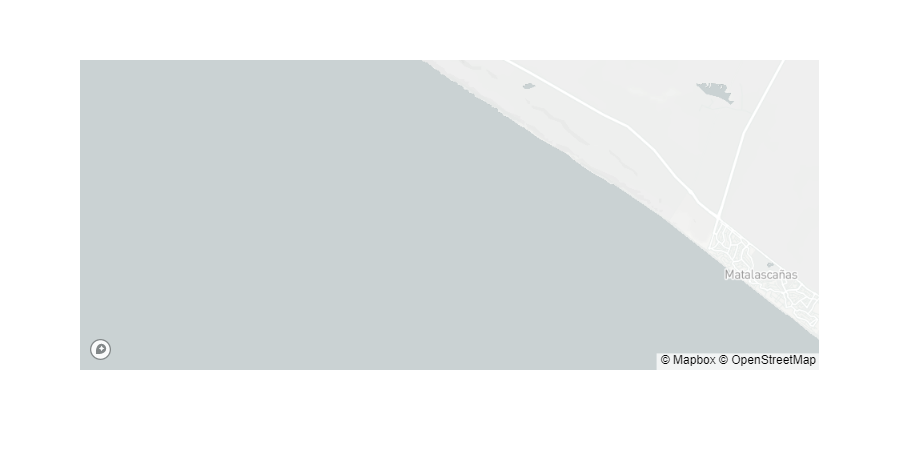